In [1]:
#
# importing the necessary libraries:
# NumPy, SciPy (optimization), 
# multiprocessing features for speed-ups, and also
# plotting functions, and a handler for csv files
#
import numpy as np
import pandas as pd
import scipy.optimize as opt
import multiprocess as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

In [2]:
#
# Number of CPU cores
#
CPU_COUNT = mp.cpu_count()

In [3]:
#
# Centering a point cloud X
#
def barycentered(X):
    #
    bar = np.sum(X, axis=1)/X.shape[1]
    #
    return X - bar[:, np.newaxis]

In [4]:
#
# First constructing a random psd matrix with specified condition number,
# then multiplying it by a random orthogonal matrix 
#
# Bierlaire, M., Toint, P., and Tuyttens, D. (1991). 
# On iterative algorithms for linear ls problems with bound constraints. 
# Linear Algebra and Its Applications, 143, 111–143.
#
def rand_mat_cond(dim=3, cond=5.0):
    #
    log_cond = np.log(cond)
    exp_vec = np.arange(-log_cond/4.0, log_cond * (dim + 1)/(4 * (dim - 1)),\
                                                                    log_cond/(2.0*(dim-1)))
    D = np.diag(np.exp(exp_vec[:dim]))
    U, _ = np.linalg.qr((np.random.rand(dim,dim) - 5.0) * 200)
    V, _ = np.linalg.qr((np.random.rand(dim,dim) - 5.0) * 200)
    P = U @ D @ V.T
    P = P @ P.T
    #
    seed = np.random.normal(0.0, 1.0, (dim,dim))
    O, _ = np.linalg.qr(seed, mode='complete')
    if np.linalg.det(O) < 0:
        O = O @ np.diag([1]*(dim-1)+[-1])
    #
    M = P @ O
    #
    return M

In [5]:
#
# Orthogonal projection onto ker X: R^n -> R^d (generically dim ker X = n-d)
#
def ortho_proj_ker(X):
    #
    Ux, Sigmax, Vx = np.linalg.svd(X)
    rank = Sigmax.shape[0]
    ker = Vx[:rank]
    proj = ker.T @ ker
    #
    return proj

In [6]:
#
# Relative Hamming distance between two permutation matrices of size mat_size
#
def hamming_dist(s1, s2, mat_size):
    return np.linalg.norm(s1 - s2, 'fro')**2 / (2*mat_size)

In [7]:
# First trying to choose the best feature matching among the number of probabilistic trials n_iter

In [8]:
"""
Running tests for the setting of multiplicative noise with point discrepancy

num_tests  = number of tests per batch (default 100)
num_points = number of points per random cloud generated (default 100)
dim = dimension (default 3)
sigma  = noise level, for N(1, \sigma^2) noise
level  = discrepancy level in (0,1], with 0 = all points removed, 1 = all points present
cond   = condition number of random linear map (default 3.0)
n_iter = number of trials for probabilistic voting (default 2**10)
"""

def test_feature_matching_best(num_tests=100, num_points=100, dim=3, sigma=0.1, level=0.95, cond=3.0, n_iter=2**10):
    #
    noise_list_best  = []
    disc_X_list_best = []
    err_L_list_best  = []
    err_Y_list_best  = []
    err_X_list_best  = []
    hamming_dist_list_best = []
    #
    for count in tqdm(range(num_tests)):
        #
        X0 = np.random.uniform(low=-1.0, high=1.0, size=(3, num_points))
        X0 = barycentered(X0)
        dim, num_y = X0.shape
        #
        num_x = int(level * num_y)
        ind = np.random.default_rng().choice(num_y, size=num_x, replace=False)
        ind = ind[np.argsort(ind)] # need to sort to be able to compare permutations later on
        X = X0[:, ind]
        X = barycentered(X)
        #
        assert(num_x <= num_y)
        #
        dX = X0[:, np.setdiff1d(np.arange(num_y), ind)]
        if dX.shape[1]>0:
            disc_X = np.linalg.norm(dX, 2) / np.linalg.norm(X0, 2)
        else:
            disc_X = .0
        disc_X_list_best += [disc_X]
        #
        #print("Dimension = {}, number of points: {} vs {}".format(dim, num_x, num_y))
        #print("Relative discrepancy = {}".format(disc_X))
        #
        I = np.identity(num_y)
        #
        L  = rand_mat_cond(dim, cond)
        #
        S  = np.random.default_rng().permutation(I)
        #
        N  = np.random.normal(1, sigma, (dim, num_y))
        #
        Y0 = L @ X0 @ S
        Y  = N * Y0
        Y  = barycentered(Y)
        #
        noise = np.linalg.norm(Y - Y0, 2) / np.linalg.norm(Y0, 2)
        noise_list_best += [noise]
        #print("Noise = {}".format(noise))
        #
        Px = ortho_proj_ker(X)
        o  = np.zeros((num_y-num_x, num_y-num_x))
        oo = np.zeros((num_y-num_x, num_x))
        Px = np.block([[Px, oo.T],[oo, o]])
        Py = ortho_proj_ker(Y)
        #
        def f_opt(i):
            np.random.seed(i) # reseed to avoid races for the RNG
            sol = opt.quadratic_assignment(Px, Py, method="faq", options = {'maximize':True, 'P0':'randomized', 'tol':1e-3})
            ind = sol['col_ind']
            s = I[ind]
            return s, i
        #
        with mp.Pool(CPU_COUNT, maxtasksperchild=int(100)) as pool:
            vals = pool.map(f_opt, range(n_iter))
        #
        def sort_key(v):
            s = v[0]
            return np.linalg.norm(Px - s @ Py @ s.T, 2)
        #
        mat, _ = sorted(vals, key=sort_key)[0]
        #
        col_ind = np.argmax(mat, axis=1)
        h_dist = hamming_dist(I[col_ind], S, num_y)
        hamming_dist_list_best += [h_dist]
        #print("Hamming distance between original and recovered permutations: {}".format(h_dist))
        #
        L0 = Y[:, col_ind][:, :num_x] @ X.T @ np.linalg.inv(X @ X.T)
        #
        err_L = np.linalg.norm(L0 - L, 2) / np.linalg.norm(L, 2)
        err_L_list_best += [err_L]
        #
        #print("Relative error in L = err_L = {}".format(err_L))
        #
        err_Y = np.linalg.norm(L @ X - L0 @ X, 2) / np.linalg.norm(L @ X, 2)
        err_Y_list_best += [err_Y]
        #
        #print("Relative error in matching images err_Y = {}".format(err_Y))
        #
        X_pre = np.linalg.inv(L0) @ Y[:, col_ind][:, :num_x]    
        err_X = np.linalg.norm(X - X_pre, 2) / np.linalg.norm(X, 2)
        err_X_list_best += [err_X]
        #
        #print("Relative error in matching inverse images err_X = {}".format(err_X))
        #
        #print("err_X : err_Y = {} ~ {} = cond(L)".format(err_X / err_Y, cond))
        #
        #img  = point3d(X.T, color='yellow', size=2)
        #img += point3d(X_pre.T, color='red', size=2)
        #img += point3d(dX.T, color='blue', size=4)
        #img.plot().show()
        #
    noise_list_best  = np.array(noise_list_best)
    disc_X_list_best = np.array(disc_X_list_best)
    err_L_list_best  = np.array(err_L_list_best)
    err_Y_list_best  = np.array(err_Y_list_best)
    err_X_list_best  = np.array(err_X_list_best)
    hamming_dist_list_best = np.array(hamming_dist_list_best)
    #
    output = {}
    output['num_x']  = num_x
    output['num_y']  = num_y 
    output['noise']  = (noise_list_best.mean(), noise_list_best.std())
    output['disc_X'] = (disc_X_list_best.mean(), disc_X_list_best.std())
    output['err_L']  = (err_L_list_best.mean(), err_L_list_best.std())
    output['err_Y']  = (err_Y_list_best.mean(), err_Y_list_best.std())
    output['err_X']  = (err_X_list_best.mean(), err_X_list_best.std())
    output['h_dist'] = (hamming_dist_list_best.mean(), hamming_dist_list_best.std())
    #
    return output

In [9]:
# Second computing the weighted feature matching from n_iter probabilistic trials 

In [10]:
"""
Running tests for the setting of multiplicative noise with point discrepancy

num_tests  = number of tests per batch (default 100)
num_points = number of points per random cloud generated (default 100)
dim = dimension (default 3)
sigma  = noise level, for N(1, \sigma^2) noise
level  = discrepancy level in (0,1], with 0 = all points removed, 1 = all points present
cond   = condition number of random linear map (default 3.0)
n_iter = number of trials for probabilistic voting (default 2**10)
"""

def test_feature_matching_weighted(num_tests=100, num_points=100, dim=3, sigma=0.1, level=0.95, cond=3.0, n_iter=2**10):
    #
    noise_list_weighted  = []
    disc_X_list_weighted = []
    err_L_list_weighted  = []
    err_Y_list_weighted  = []
    err_X_list_weighted  = []
    hamming_dist_list_weighted = []
    #
    for count in tqdm(range(num_tests)):
        #
        X0 = np.random.uniform(low=-1.0, high=2.0, size=(dim, num_points))
        X0 = barycentered(X0)
        dim, num_y = X0.shape
        #
        num_x = int(level * num_y)
        ind = np.random.default_rng().choice(num_y, size=num_x, replace=False)
        ind = ind[np.argsort(ind)] # need to sort to be able to compare permutations later on
        X = X0[:, ind]
        X = barycentered(X)
        #
        assert(num_x <= num_y)
        #
        dX = X0[:, np.setdiff1d(np.arange(num_y), ind)]
        #
        if dX.shape[1]>0:
            disc_X = np.linalg.norm(dX, 2) / np.linalg.norm(X0, 2)
        else:
            disc_X = .0
        #
        disc_X_list_weighted += [disc_X]
        #
        #print("Dimension = {}, number of points: {} vs {}".format(dim, num_x, num_y))
        #print("Relative discrepancy = {}".format(disc_X))
        #
        I = np.identity(num_y)
        #
        L  = rand_mat_cond(dim, cond)
        #
        S  = np.random.default_rng().permutation(I)
        #
        N  = np.random.normal(1, sigma, (dim, num_y))
        #
        Y0 = L @ X0 @ S
        Y  = N * Y0
        Y  = barycentered(Y)
        #
        noise = np.linalg.norm(Y - Y0, 2) / np.linalg.norm(Y0, 2)
        noise_list_weighted += [noise]
        #print("Noise = {}".format(noise))
        #
        Px = ortho_proj_ker(X)
        o  = np.zeros((num_y-num_x, num_y-num_x))
        oo = np.zeros((num_y-num_x, num_x))
        Px = np.block([[Px, oo.T],[oo, o]])
        Py = ortho_proj_ker(Y)
        #
        def f_opt(i):
            np.random.seed(i) # reseed to avoid races for the RNG
            sol = opt.quadratic_assignment(Px, Py, method="faq", options = {'maximize':True, 'P0':'randomized', 'tol':1e-3})
            ind = sol['col_ind']
            s = I[ind]
            weight = np.exp(-1000.0*(np.trace(Px @ s @ Py @ s.T) - dim)**2)
            return weight, s, i
        #
        with mp.Pool(CPU_COUNT, maxtasksperchild=int(100)) as pool:
            vals = pool.map(f_opt, range(n_iter))
        #
        mat = sum([v[0]*v[1] for v in vals])
        #
        row_ind, col_ind = opt.linear_sum_assignment(mat, maximize=True)
        #
        h_dist = hamming_dist(I[col_ind], S, num_y)
        hamming_dist_list_weighted += [h_dist]
        #print("Hamming distance between original and recovered permutations: {}".format(h_dist))
        #
        L0 = Y[:, col_ind][:, :num_x] @ X.T @ np.linalg.inv(X @ X.T)
        #
        err_L = np.linalg.norm(L0 - L, 2) / np.linalg.norm(L, 2)
        err_L_list_weighted += [err_L]
        #
        #print("Relative error in L = err_L = {}".format(err_L))
        #
        err_Y = np.linalg.norm(L @ X - L0 @ X, 2) / np.linalg.norm(L @ X, 2)
        err_Y_list_weighted += [err_Y]
        #
        #print("Relative error in matching images err_Y = {}".format(err_Y))
        #
        X_pre = np.linalg.inv(L0) @ Y[:, col_ind][:, :num_x]    
        err_X = np.linalg.norm(X - X_pre, 2) / np.linalg.norm(X, 2)
        err_X_list_weighted += [err_X]
        #
        #print("Relative error in matching inverse images err_X = {}".format(err_X))
        #
        #print("err_X : err_Y = {} ~ {} = cond(L)".format(err_X / err_Y, cond))
        #
    #
    noise_list_weighted  = np.array(noise_list_weighted)
    disc_X_list_weighted = np.array(disc_X_list_weighted)
    err_L_list_weighted  = np.array(err_L_list_weighted)
    err_Y_list_weighted  = np.array(err_Y_list_weighted)
    err_X_list_weighted  = np.array(err_X_list_weighted)
    hamming_dist_list_weighted = np.array(hamming_dist_list_weighted)
    #
    output = {}
    output['num_x']  = num_x
    output['num_y']  = num_y 
    output['noise']  = (noise_list_weighted.mean(), noise_list_weighted.std())
    output['disc_X'] = (disc_X_list_weighted.mean(), disc_X_list_weighted.std())
    output['err_L']  = (err_L_list_weighted.mean(), err_L_list_weighted.std())
    output['err_Y']  = (err_Y_list_weighted.mean(), err_Y_list_weighted.std())
    output['err_X']  = (err_X_list_weighted.mean(), err_X_list_weighted.std())
    output['h_dist'] = (hamming_dist_list_weighted.mean(), hamming_dist_list_weighted.std())
    #
    return output

In [11]:
# Collecting some quick stats for "choosing the best feature correspondence" approach

In [22]:
out_best = test_feature_matching_best(num_tests=100, num_points=100, dim=3,\
                                      sigma=0.1, level=1.0, cond=3.0, n_iter=2**7)
#
df_best  = pd.DataFrame.from_dict(out_best, orient='index', columns=['Value'])
#
print(df_best)

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

                                              Value
num_x                                           100
num_y                                           100
noise   (0.08562757265815076, 0.008805664097259308)
disc_X                                   (0.0, 0.0)
err_L    (0.15083811846810735, 0.36355940659499897)
err_Y     (0.1457868564039155, 0.35269368589737427)
err_X    (0.19842377552151322, 0.05133371571186018)
h_dist                (0.1468, 0.26922065299675657)


In [13]:
# Collecting stats for "feature correspondence from the weighted sum" approach

In [23]:
out_weighted = test_feature_matching_weighted(num_tests=100, num_points=100, dim=3,\
                                              sigma=0.1, level=1.0, cond=3.0, n_iter=2**7)
#
df_weighted  = pd.DataFrame.from_dict(out_weighted, orient='index', columns=['Value'])
#
print(df_weighted)

100%|██████████| 100/100 [00:30<00:00,  3.30it/s]

                                              Value
num_x                                           100
num_y                                           100
noise   (0.08432110984221872, 0.007583378688837096)
disc_X                                   (0.0, 0.0)
err_L     (0.07248010788257911, 0.2779250753455331)
err_Y     (0.06987997049827727, 0.2680738090522467)
err_X   (0.18908714786332678, 0.037851734283778984)
h_dist   (0.08259999999999999, 0.16058405898469502)


In [15]:
"""
Defining the test parameters:
num_tests  = number of tests per batch (default 100)
num_points = number of points per random cloud generated (default 100)
dim = dimension (default 3)
sigma  = noise level, for N(1, \sigma^2) noise
level  = discrepancy level in (0,1], with 0 = all points removed, 1 = all points present
cond   = condition number of random linear map (default 3.0)
n_iter = number of trials for probabilistic voting (default 2**10)
""";

In [16]:
#
num_tests  = 100
num_points = 100
dim = 3
level = 1.0
cond = 3.0
#
# Noise level: sigma varies from 0.05 to 0.25 with step 0.05
sigma_values = np.arange(0.05, 0.30, 0.05)  
# Number of probabilistic votes varies from 32 (2^5) to 1024 (2^10)
n_iter_values = 2**np.arange(5, 11) 
#

In [17]:
# Heatmap for various values of noise magnitude and number of probabilistic votes
# for "choosing the best" approach

In [18]:
# Initialize the heatmap
heatmap_err_L_best  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_err_Y_best  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_err_X_best  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_h_dist_best = np.zeros((len(sigma_values), len(n_iter_values)))
# Populate the heatmap
for i, sigma in enumerate(sigma_values):
    for j, n_iter in enumerate(n_iter_values):
        #
        out_best = test_feature_matching_best(num_tests, num_points, dim, sigma,\ 
                                              level, cond, n_iter)
        # 
        heatmap_err_L_best[i, j],  _  = out_best['err_L']
        heatmap_err_Y_best[i, j],  _  = out_best['err_Y']
        heatmap_err_X_best[i, j],  _  = out_best['err_X']
        heatmap_h_dist_best[i, j], _  = out_best['h_dist']

100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


In [19]:
# Heatmap for various values of noise magnitude and number of probabilistic votes
# for "weighted sum" approach

In [20]:
# Initialize the heatmap
heatmap_err_L_weighted  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_err_Y_weighted  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_err_X_weighted  = np.zeros((len(sigma_values), len(n_iter_values)))
heatmap_h_dist_weighted = np.zeros((len(sigma_values), len(n_iter_values)))
# Populate the heatmap
for i, sigma in enumerate(sigma_values):
    for j, n_iter in enumerate(n_iter_values):
        #
        out_weighted = test_feature_matching_weighted(num_tests, num_points, dim, sigma,\
                                                      level, cond, n_iter)
        # 
        heatmap_err_L_weighted[i, j],  _  = out_weighted['err_L']
        heatmap_err_Y_weighted[i, j],  _  = out_weighted['err_Y']
        heatmap_err_X_weighted[i, j],  _  = out_weighted['err_X']
        heatmap_h_dist_weighted[i, j], _  = out_weighted['h_dist']

100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


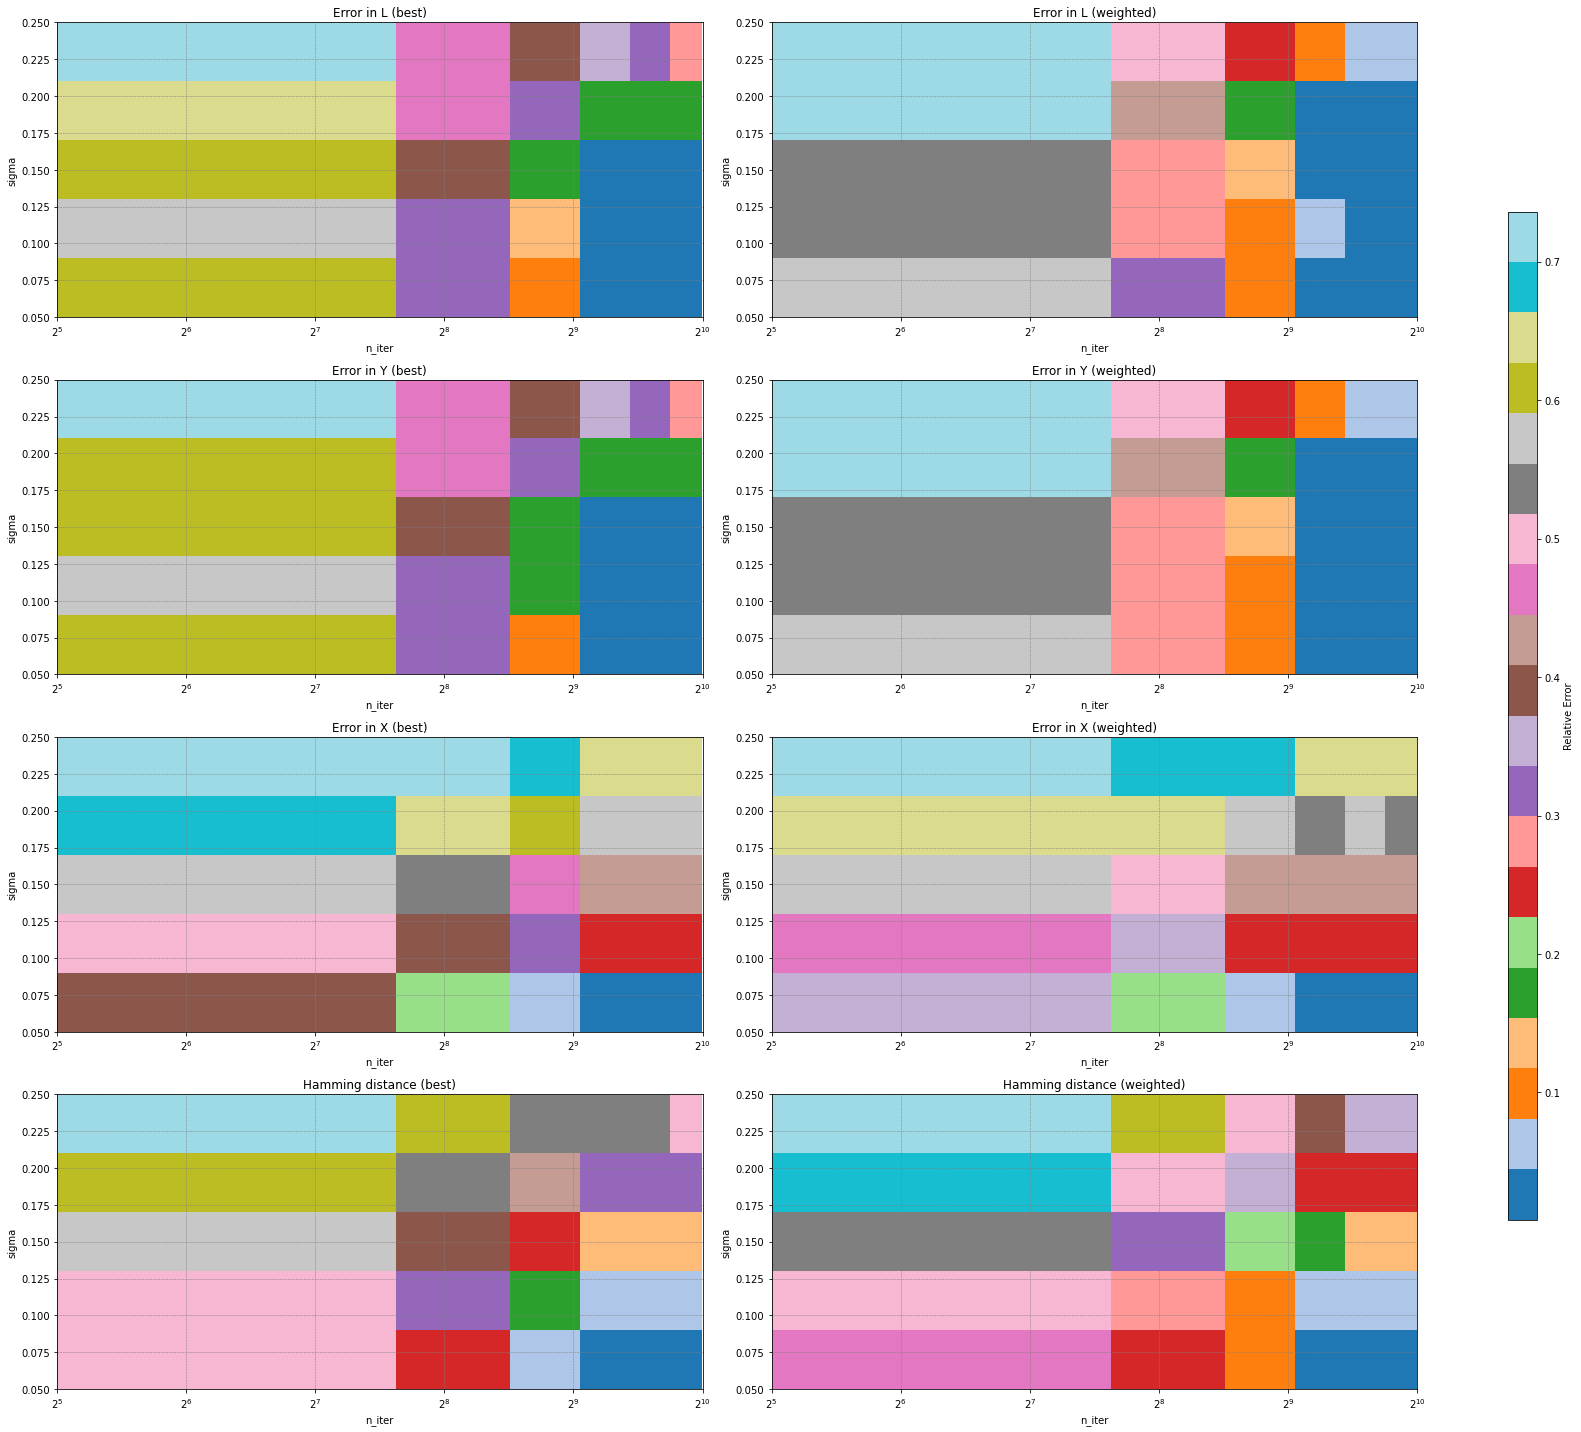

In [26]:
#
# Create the heatmap plot
#
heatmap_data = [(heatmap_err_L_best, 'Error in L (best)'),
                (heatmap_err_L_weighted, 'Error in L (weighted)'),
                (heatmap_err_Y_best, 'Error in Y (best)'),
                (heatmap_err_Y_weighted, 'Error in Y (weighted)'),
                (heatmap_err_X_best, 'Error in X (best)'),
                (heatmap_err_X_weighted, 'Error in X (weighted)'),
                (heatmap_h_dist_best, 'Hamming distance (best)'),
                (heatmap_h_dist_weighted, 'Hamming distance (weighted)')]
#
# Create a 4x2 grid for the subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
#
# Create a common axis for the colorbar
cax = fig.add_axes([1.05, 0.15, 0.02, 0.7])  
#
for i, ax in enumerate(axs.flatten()):
    data, description = heatmap_data[i]
    im = ax.imshow(data, cmap='tab20', origin='lower', aspect='auto',
                   extent=[n_iter_values[0], n_iter_values[-1], sigma_values[0], sigma_values[-1]])
    ax.set_xlabel('n_iter')
    ax.set_ylabel('sigma')
    ax.set_title(description)
    ax.set_xscale('log', base=2)
    ax.set_yscale('linear')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')

# Create a common colorbar using the cax parameter
fig.colorbar(im, cax=cax, label="Relative Error")

plt.tight_layout()
plt.show()